In [1]:
%matplotlib inline
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from sklearn.linear_model import SGDClassifier
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.metrics import classification_report, confusion_matrix
import pandas as pd

reader = pd.read_json('~/Downloads/reviews_Baby_5.json.gz', lines=True, chunksize=40000)

for val in reader:
    break

#reader.chunksize = 100

hv = HashingVectorizer(analyzer='word', ngram_range=(1,2), n_features=2**18)
clf = SGDClassifier(loss='hinge', max_iter=1)

X_val = hv.transform(val['reviewText'])

# rating_counts = val.groupby('overall')['overall'].size()
# rating_weights = (1/rating_counts).to_dict()
rating_weights = {1:1, 2:1, 3:1, 4:1, 5:1}

ci = 0
for chunk in reader:
    print('chunk {}'.format(ci))
    ci+=1
    X = hv.transform(chunk['reviewText'])
    y = chunk['overall']
    clf.partial_fit(X, y, classes=[1, 2, 3, 4, 5], sample_weight=chunk.overall.map(lambda r: rating_weights[r]))
    val_p = clf.predict(X_val)
    report = classification_report(val['overall'], val_p)
    print(report)
    print(confusion_matrix(val['overall'], val_p))
    break


chunk 0
              precision    recall  f1-score   support

           1       0.69      0.17      0.28      2336
           2       0.34      0.04      0.07      2540
           3       0.33      0.34      0.33      4257
           4       0.46      0.27      0.34      7933
           5       0.71      0.94      0.81     22934

   micro avg       0.64      0.64      0.64     40000
   macro avg       0.51      0.35      0.37     40000
weighted avg       0.60      0.64      0.59     40000

[[  408   115   654   180   979]
 [  111    99   995   335  1000]
 [   45    49  1438  1043  1682]
 [    9    12   837  2106  4969]
 [   21    20   485   886 21522]]


Text(0.5, 1.0, 'number of ratings per `overall`')

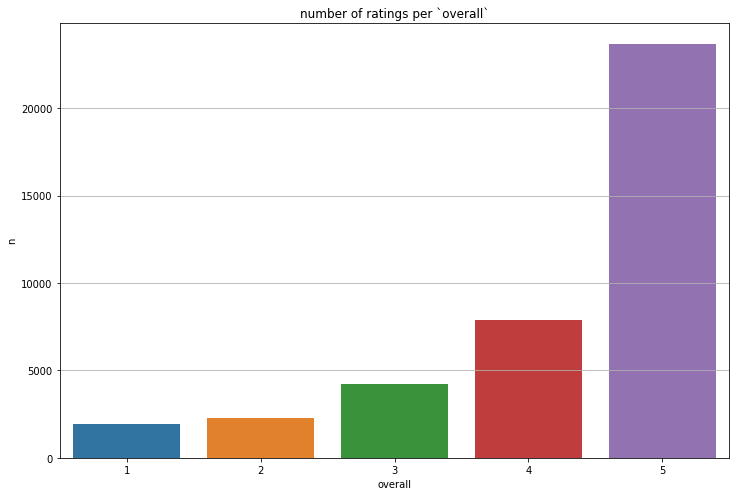

In [3]:
rating_counts = chunk.groupby('overall').size().reset_index().rename(index=str, columns={0: 'n'})
plt.figure(figsize=(12,8)); plt.grid(True)
sns.barplot(x='overall', y='n', data=rating_counts)
plt.title('number of ratings per `overall`')

/home/phil/miniconda3/envs/svm/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Text(0.5, 1.0, 'log10 number of reviews per asin')

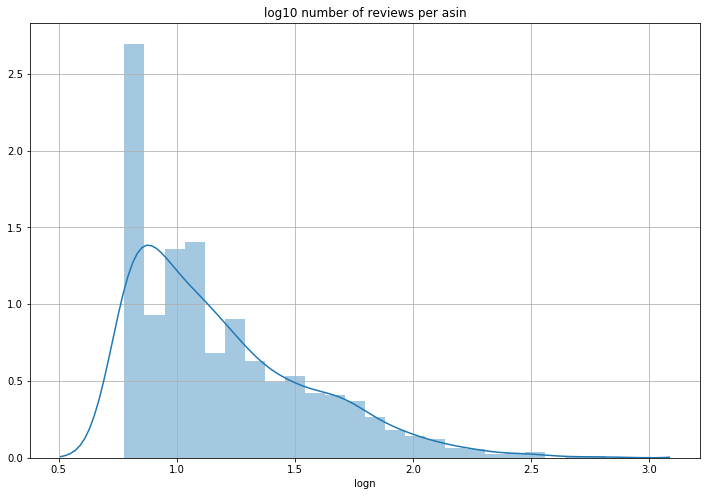

In [4]:
asin_rc = chunk.groupby('asin').size().reset_index().rename(index=str, columns={0:'n'}).sort_values('n', ascending=False)
asin_rc['logn'] = np.log10(asin_rc.n+1)
plt.figure(figsize=(12,8)); plt.grid(True)
sns.distplot(asin_rc.logn)
plt.title('log10 number of reviews per asin')

Text(0, 0.5, 'log10 number of tokens')

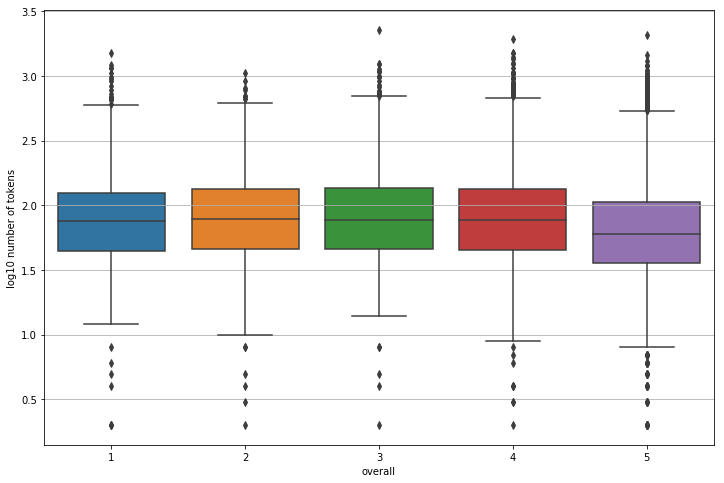

In [5]:
chunk['token_len'] = chunk['reviewText'].map(lambda t: np.log10(len(t.split(" "))+1))
plt.figure(figsize=(12,8)); plt.grid(True)
sns.boxplot(x='overall', y='token_len', data=chunk)
plt.ylabel('log10 number of tokens')

Text(0.5, 1.0, 'median number of words per reviewer')

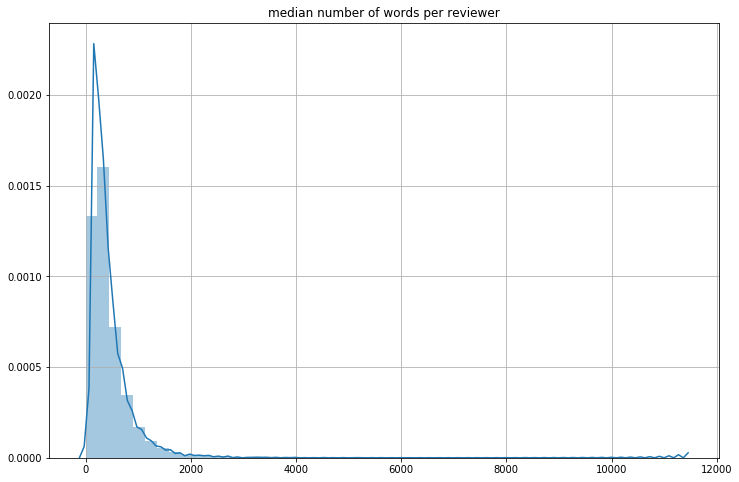

In [6]:
def f(rows):
    return rows.map(lambda r: len(r)).median()
median_postlengths = chunk.groupby('reviewerID').agg({'reviewText': f}).rename(index=str, columns={'reviewText': 'postlength'})
plt.figure(figsize=(12,8)); plt.grid(True)
sns.distplot(median_postlengths)
plt.title('median number of words per reviewer')

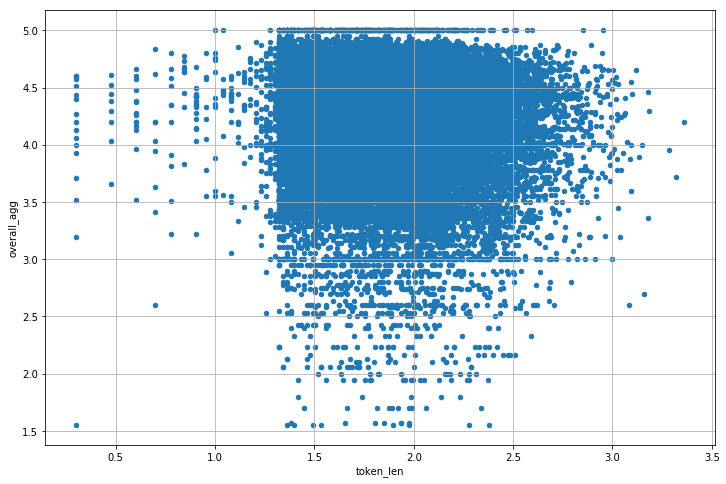

In [7]:
chunk.set_index('asin').join(
    chunk.groupby('asin').agg({'overall': np.mean}), rsuffix="_agg"
)[['token_len', 'overall_agg']].plot.scatter(x='token_len', y='overall_agg', figsize=(12,8), grid=True)

Text(0, 0.5, 'mean asin rating')

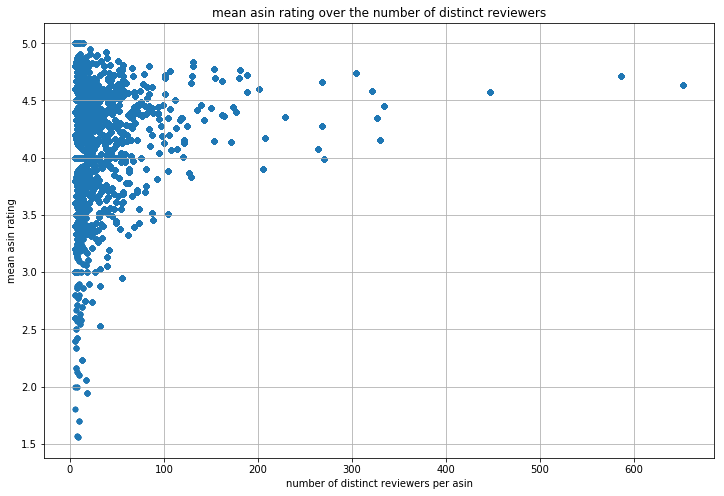

In [8]:
chunk.set_index('asin').join(
    chunk.groupby('asin').agg({'reviewerID': lambda r: r.nunique(), 'overall': lambda o: o.mean()}), rsuffix="_agg"
)[['reviewerID_agg', 'overall_agg']].plot.scatter(
    x='reviewerID_agg',
    y='overall_agg',
    figsize=(12,8),
    grid=True,
    title='mean asin rating over the number of distinct reviewers',
)

plt.xlabel('number of distinct reviewers per asin')
plt.ylabel('mean asin rating')
